<a href="https://colab.research.google.com/github/anton1evdokimov/1561087-cinemaddict-16/blob/master/evdokimov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

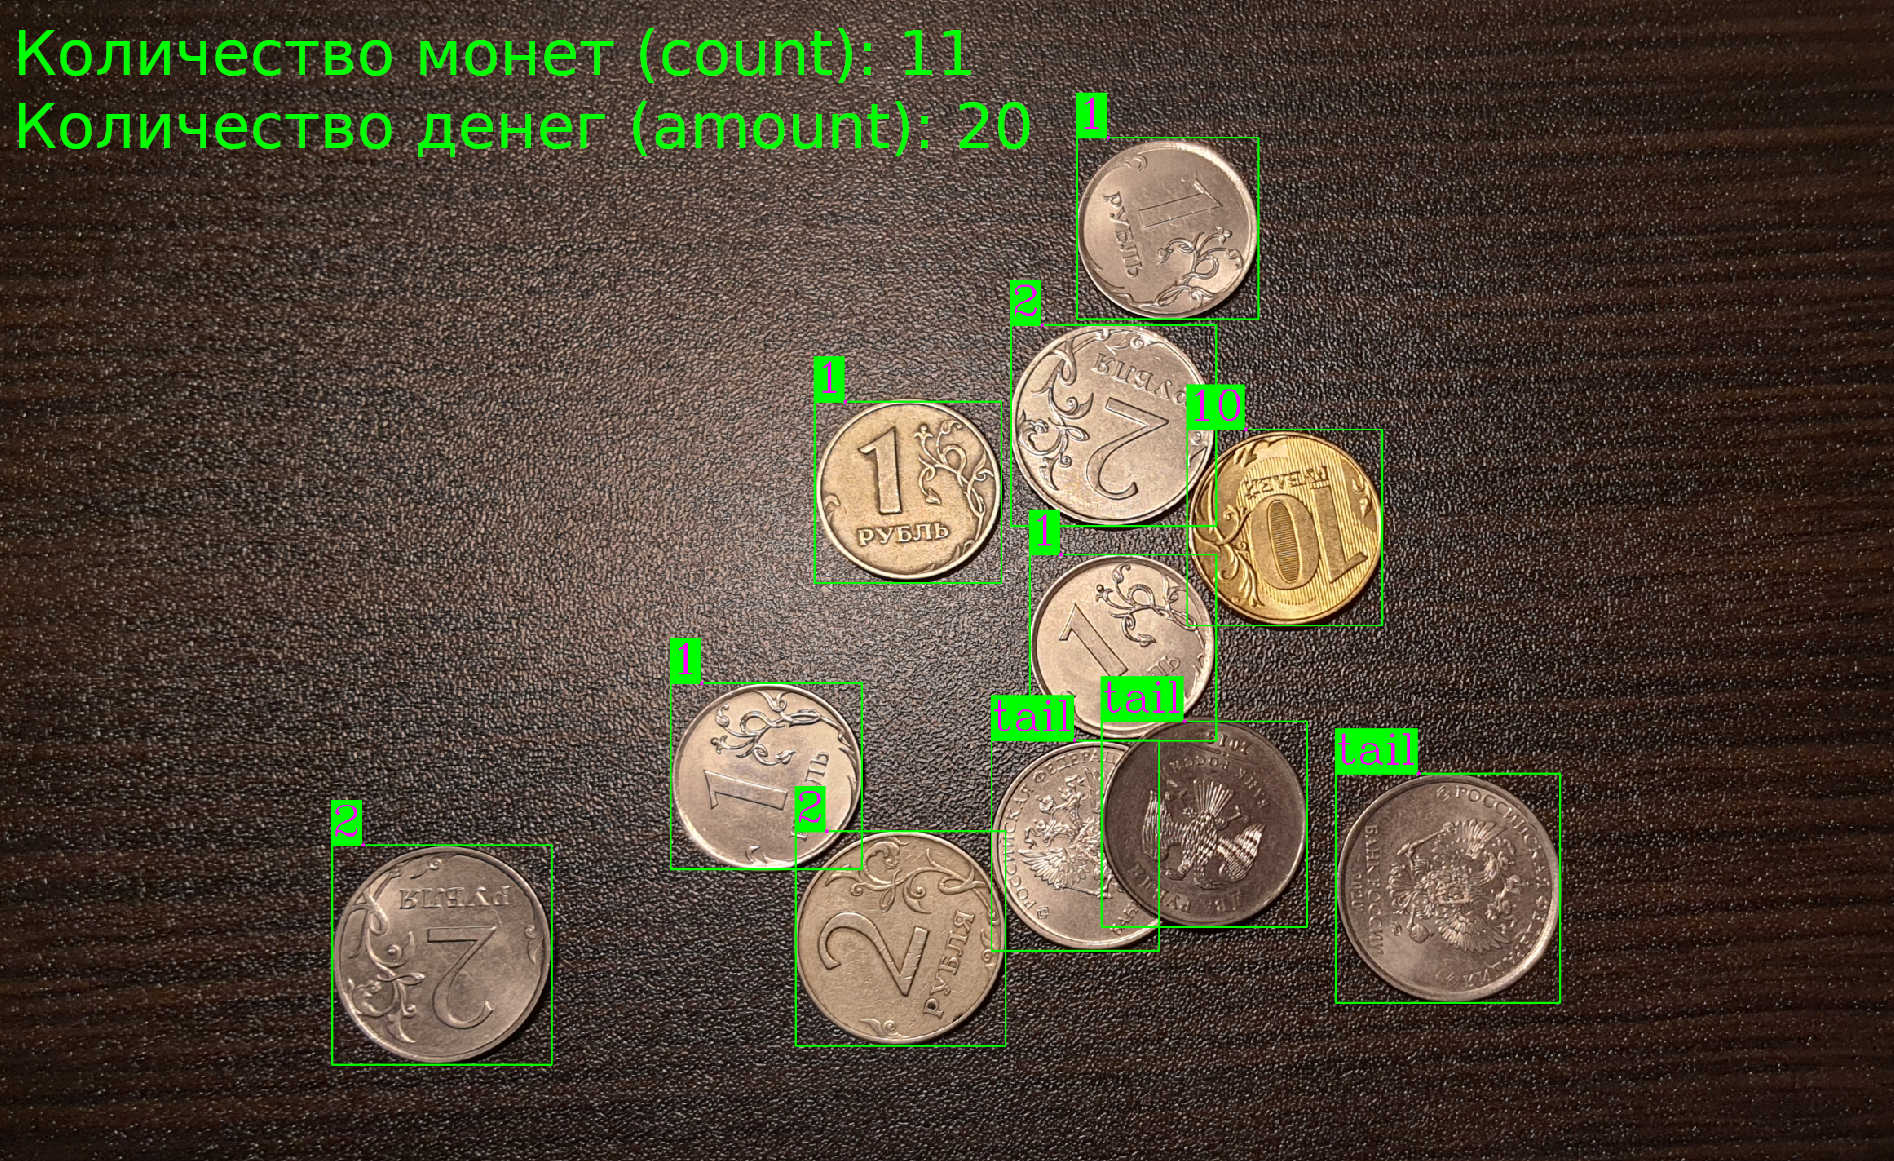

# Задача
1. Посчитать число монет (count) на каждом фото в тестовой выборке
2. Посчитать сумму монет (amount) решкой вверх на каждом фото в выборке. Если монетка лежит решкой вниз - она игнорируется

# Оценка
1. По каждой задаче будет вычислена метрика на закрытой тестовой выборке. В данном ноутбуке предоставлена заготовка для оценки целевых метрик качества на открытом тесте
2. Метрика первой задачи: средняя относительная ошибка количества предсказанных монет на изображении. Чем меньше, тем лучше

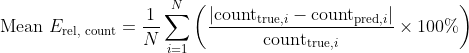

3. Метрика второй задачи: средняя относительная ошибка количества предсказанных денег на изображении. Перевернутые монеты решкой вниз игнорируются. Чем меньше, тем лучше

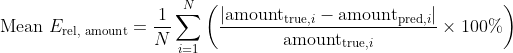

4. Учитывается скорость создания решения
5. Учитывается качество оформление кода и ноутбука

# Рекомендация
1. Задачу рекомендуется решить через обучение детектора (yolo, faster-rcnn, retina-net и пр.) с **синтетической обучающей выборкой, т.е. генерироваться программно через питон. Можно использовать в качестве заготовок и текстур любые изображения из интернета или вырезать из предоставленной выборки**
1. Фреймворк машинного обучения не имеет значения, но лучше использовать torchvision
1. Можно использовать предобработку изображения перед подачей в детектор
1. В процессе создания датасета и настройки модели не пользуйтесь GPU в google-colab, включите его только когда нужно будет запускать обучение
1. В случае даже если вы не успели сделать задачу, все равно постарайтесь опубликовать как можно более красивый ноутбук с презентацией сделанных шагов
1. Данные для задачи можете залить на гугл-диск и загрузить в колаб через библиотеку `gdown`. Обратите внимание `link_id` нужно взять из ссылки при расшаривании папки (или файла) через гугл-диск

# Ограничения
1. **Запрещено** делать разметку на предоставленных изображениях для обучения детектора
1. Нужно предоставить код создания синтетического датасета, код обучения, и оценку качества по п. 1 и 2. Все шаги должны быть повторяемые через перезапуск всех ячеек (клавиша Ctrl+F9). Можно предоставить решение не в google colab с использованием докера: в этом случае обязательно нужно предоставить инструкцию для повторения всех шагов.



In [2]:
import urllib
import cv2
import numpy as np
import urllib
import requests
from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
import gdown
import zipfile
import json
from tqdm.auto import tqdm

# Input

## Скачиваем данные

In [3]:
zip_path = "split1.zip"
data_dir = "split1"
link_id = "1l5m4kWospsEcE32lpRT_tPnTabF3fPhp"
gdown.download(f"https://drive.google.com/uc?id={link_id}", zip_path)

Downloading...
From (original): https://drive.google.com/uc?id=1l5m4kWospsEcE32lpRT_tPnTabF3fPhp
From (redirected): https://drive.google.com/uc?id=1l5m4kWospsEcE32lpRT_tPnTabF3fPhp&confirm=t&uuid=30b140ae-3fec-421c-9b2b-ca4e197432e7
To: /content/split1.zip
100%|██████████| 124M/124M [00:01<00:00, 79.3MB/s]


'split1.zip'

In [4]:
with zipfile.ZipFile(zip_path) as zip_file:
  zip_file.extractall(data_dir)

In [6]:
ground_truth_path = Path(data_dir, "counts.json")
images_dir = Path(data_dir, "images")

assert ground_truth_path.exists(), ground_truth_path
assert images_dir.exists(), images_dir

In [7]:
with open(ground_truth_path) as f:
  ground_truth_data = json.load(f)

## Функция для оценки метрик

In [8]:
def compute_relative_error(prediction, gt):
  return abs(prediction - gt)/gt * 100

## Baseline модель для примера вычисления метрик

In [9]:
count_amount_coef = np.mean([v["amount"]/v["count"] for v in ground_truth_data.values()])
count_amount_coef

1.3927061973114605

In [10]:
class MyModel:  # Ваша Модель
  def __init__(self, dp=1.5,
               minDist=20,
               minRadius=15,
               maxRadius=50,
               count_amount_coef=0.5):
    self.dp = dp
    self.minDist = minDist
    self.minRadius = minRadius
    self.maxRadius = maxRadius
    self.count_amount_coef = count_amount_coef


  def train(self):  # Тут должно быть обучение
    pass

  def predict(self, image_path):   # Пример на классике без обучения
    image = cv2.imread(str(Path(images_dir, image_name)))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (31, 31), 3.0)
    image = cv2.resize(image, (1008, 567))

    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    tmp = clahe.apply(tmp)

    tmp = cv2.GaussianBlur(tmp, (5, 5), 0)
    circles = cv2.HoughCircles(tmp, cv2.HOUGH_GRADIENT, dp=self.dp, minDist=self.minDist, minRadius=self.minRadius, maxRadius=self.maxRadius)

    color = [255, 255, 255]
    output = image.copy()

    coins_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        coins_count = len(circles)
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)

    self.debug_output = output

    amount_count = coins_count*self.count_amount_coef  # Для примера
    return coins_count, amount_count

In [11]:
model = MyModel(count_amount_coef=count_amount_coef)
model.train()  # Запускаем обучение

### Вычисление метрик baseline-модели

In [12]:
count_errors = []
amount_errors = []
DEBUG = False

for image_name, gt in tqdm(sorted(ground_truth_data.items(), reverse=True)):
  predict_count, predict_amount = model.predict(Path(images_dir, image_name))

  count_error = compute_relative_error(predict_count, gt["count"])
  amount_error = compute_relative_error(predict_amount, gt["amount"])

  if DEBUG:
    print(image_name)
    print(f"pred {predict_count}, gt {gt['count']}, {count_error=}%")
    print(f"pred {predict_amount}, gt {gt['amount']}, {amount_error=}%")
    print()

  count_errors.append(count_error)
  amount_errors.append(amount_error)

print()
print(f"\033[91mМетрика 1. Средняя относительная ошибка количества монет: {round(np.mean(count_errors), 1)}%")
print(f"\033[91mМетрика 2. Средняя относительная ошибка количества денег: {round(np.mean(amount_errors), 1)}%")

  0%|          | 0/38 [00:00<?, ?it/s]


Метрика 1. Средняя относительная ошибка количества монет: 7.7%
Метрика 2. Средняя относительная ошибка количества денег: 35.9%


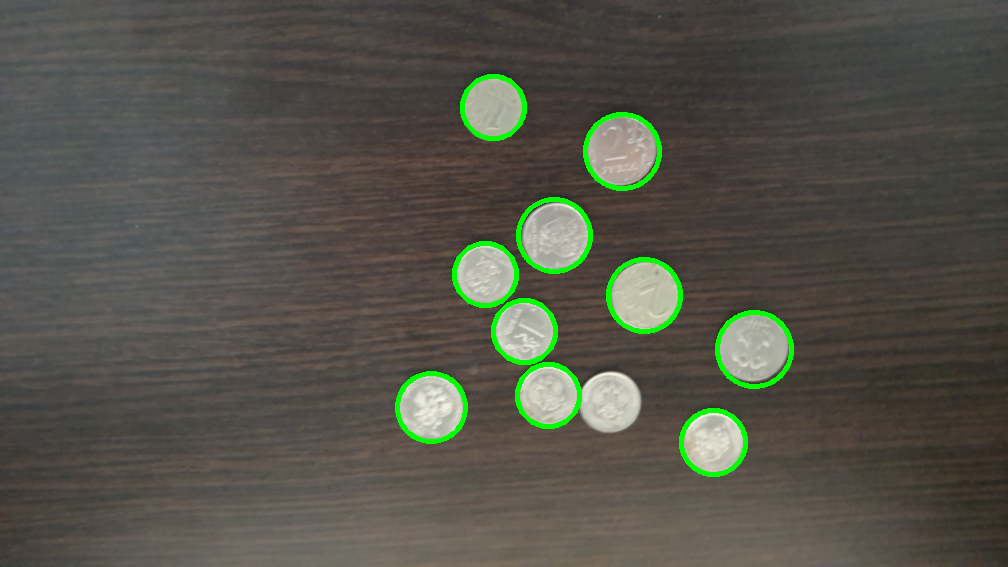

In [ ]:
Image.fromarray(model.debug_output)